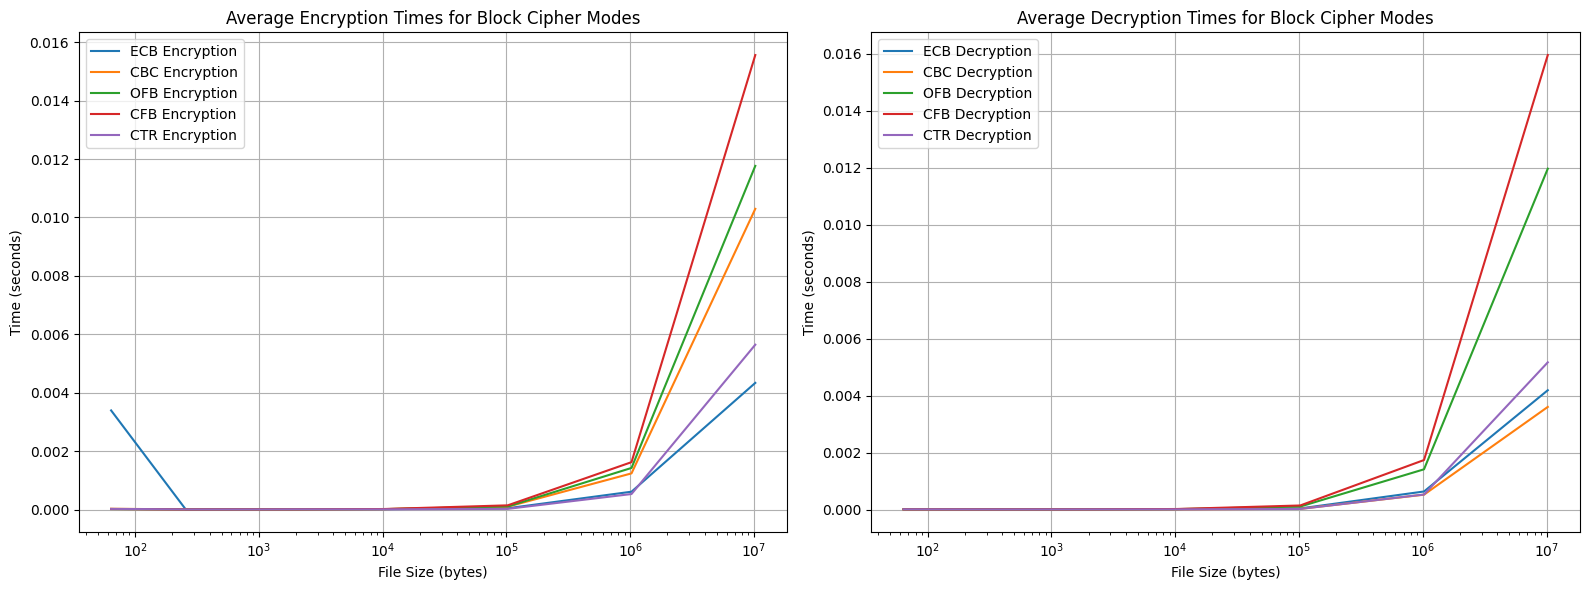

In [1]:
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.backends import default_backend
import os
import time

def encrypt_decrypt(mode, key, iv, data, operation):
    cipher = Cipher(algorithms.AES(key), mode, backend=default_backend())
    if operation == "encrypt":
        encryptor = cipher.encryptor()
        return encryptor.update(data) + encryptor.finalize()
    elif operation == "decrypt":
        decryptor = cipher.decryptor()
        return decryptor.update(data) + decryptor.finalize()

def measure_time(mode, key, iv, data):
    start = time.time()
    encrypted = encrypt_decrypt(mode, key, iv, data, "encrypt")
    encryption_time = time.time() - start

    start = time.time()
    decrypted = encrypt_decrypt(mode, key, iv, encrypted, "decrypt")  # Fixed function call
    decryption_time = time.time() - start

    return encryption_time, decryption_time

file_sizes = [64, 256, 512, 1024, 2048 ,10240, 102400, 1024000, 1024*10000]  # Sizes in bytes (1 KB, 10 KB, 100 KB)
test_files = []

for size in file_sizes:
    test_files.append(os.urandom(size))



key = os.urandom(32)  # 256-bit key
iv = os.urandom(16)   # 128-bit IV

modes_list = [
    modes.ECB(),
    modes.CBC(iv),
    modes.OFB(iv),
    modes.CFB(iv),
    modes.CTR(iv)
]
n = 5  # Number of repetitions for each test

results = {}

for mode in modes_list:
    mode_name = mode.__class__.__name__
    results[mode_name] = []
    for data in test_files:
        total_enc_time = 0
        total_dec_time = 0
        for _ in range(n):  # Repeat the test n times
            enc_time, dec_time = measure_time(mode, key, iv, data)
            total_enc_time += enc_time
            total_dec_time += dec_time
        # Calculate average times
        avg_enc_time = total_enc_time / n
        avg_dec_time = total_dec_time / n
        results[mode_name].append((avg_enc_time, avg_dec_time))
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # Create two subplots side by side

# Wykres dla szyfrowania (Encryption)
axes[0].set_title("Average Encryption Times for Block Cipher Modes")
for mode_name, times in results.items():
    enc_times, _ = zip(*times)
    axes[0].plot(file_sizes, enc_times, label=f"{mode_name} Encryption")
axes[0].set_xlabel("File Size (bytes)")
axes[0].set_ylabel("Time (seconds)")
axes[0].set_xscale("log")  # Opcjonalnie: skala logarytmiczna dla osi X
axes[0].legend()
axes[0].grid(True)

# Wykres dla deszyfrowania (Decryption)
axes[1].set_title("Average Decryption Times for Block Cipher Modes")
for mode_name, times in results.items():
    _, dec_times = zip(*times)
    axes[1].plot(file_sizes, dec_times, label=f"{mode_name} Decryption")
axes[1].set_xlabel("File Size (bytes)")
axes[1].set_ylabel("Time (seconds)")
axes[1].set_xscale("log")  # Opcjonalnie: skala logarytmiczna dla osi X
axes[1].legend()
axes[1].grid(True)



plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

## wyniki:
aż to 10^5 fukcje działająze znikomą różnicą.
najwolniej szyfruje i deszyfruje CFB, na 2 miejscu OFB.


### CFB (Cipher Feedback Mode):
W trybie CFB każdy blok szyfrowania zależy od poprzedniego bloku szyfrogramu. Oznacza to, że szyfrowanie i deszyfrowanie muszą być wykonywane sekwencyjnie (brak możliwości równoległego przetwarzania).
Dodatkowo, w CFB szyfrowanie wymaga operacji XOR na każdym bloku, co zwiększa czas przetwarzania

### OFB  (Output Feedback Mode):
Podobnie jak w CFB, OFB działa w sposób sekwencyjny. Każdy blok wyjściowy zależy od poprzedniego, co uniemożliwia równoległe przetwarzanie.
Jednak w OFB szyfrowanie jest nieco szybsze niż w CFB, ponieważ operacja XOR jest wykonywana na danych wejściowych, a nie na szyfrogramie.

### ECB (Electronic Codebook Mode):
Każdy blok jest szyfrowany niezależnie, co pozwala na równoległe przetwarzanie. Dlatego jest najszybszy, ale najmniej bezpieczny (łatwo zauważyć wzorce w danych).
Każdy blok tekstu jawnego jest szyfrowany niezależnie za pomocą algorytmu szyfrującego (np. AES).
Nie ma żadnych dodatkowych operacji, takich jak XOR czy generowanie licznika.



### CTR (Counter Mode):

CTR generuje unikalny licznik (counter) dla każdego bloku, który jest szyfrowany za pomocą algorytmu szyfrującego (np. AES).
Wynik szyfrowania licznika jest następnie XOR-owany z tekstem jawnym, aby uzyskać szyfrogram.

### CBC (Cipher Block Chaining Mode):
W trybie CBC (Cipher Block Chaining) różnica w szybkości między szyfrowaniem a deszyfrowaniem wynika z różnicy w sposobie, w jaki dane są przetwarzane.

Szyfrowanie w CBC jest szybsze, ponieważ operacja XOR jest prostsza i szybsza, a algorytm szyfrowania (np. AES) jest zoptymalizowany do szyfrowania.
Deszyfrowanie w CBC jest wolniejsze, ponieważ wymaga bardziej złożonych operacji deszyfrowania i dodatkowego przetwarzania (XOR z poprzednim blokiem szyfrogramu).



| **Tryb** | **Propagacja błędów** | **Skutki błędu**                     |
|----------|-----------------------|--------------------------------------|
| **ECB**  | Brak                  | Wpływa tylko na jeden blok.          |
| **CBC**  | Ograniczona           | Wpływa na dwa bloki (bieżący i następny). |
| **CFB**  | Globalna              | Wpływa na bieżący i wszystkie kolejne bloki. |
| **OFB**  | Brak                  | Wpływa tylko na jeden blok.          |
| **CTR**  | Brak                  | Wpływa tylko na jeden blok.          |

Wynika to ze sposobu szyfrowania, czy dany algorytm korzysta z poprzednich bloków, czy nie. Opisy algorytmów są wyżej

In [2]:

from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.backends import default_backend
import os

def xor_bytes(a, b):
    """XOR two byte strings."""
    return bytes(x ^ y for x, y in zip(a, b))

def cbc_encrypt(key, iv, plaintext, block_size=16):
    """Encrypt plaintext using CBC mode with ECB as the base mode."""
    cipher = Cipher(algorithms.AES(key), modes.ECB(), backend=default_backend())
    encryptor = cipher.encryptor()

    ciphertext = b""
    previous_block = iv

    # Pad plaintext to be a multiple of the block size
    padding_length = block_size - (len(plaintext) % block_size)
    plaintext += bytes([padding_length] * padding_length)

    for i in range(0, len(plaintext), block_size):
        block = plaintext[i:i + block_size]
        xored_block = xor_bytes(block, previous_block)
        encrypted_block = encryptor.update(xored_block)
        ciphertext += encrypted_block
        previous_block = encrypted_block

    return ciphertext

def cbc_decrypt(key, iv, ciphertext, block_size=16):
    """Decrypt ciphertext using CBC mode with ECB as the base mode."""
    cipher = Cipher(algorithms.AES(key), modes.ECB(), backend=default_backend())
    decryptor = cipher.decryptor()

    plaintext = b""
    previous_block = iv

    for i in range(0, len(ciphertext), block_size):
        block = ciphertext[i:i + block_size]
        decrypted_block = decryptor.update(block)
        xored_block = xor_bytes(decrypted_block, previous_block)
        plaintext += xored_block
        previous_block = block

    # Remove padding
    padding_length = plaintext[-1]
    plaintext = plaintext[:-padding_length]

    return plaintext

# Example usage
key = os.urandom(32)  # 256-bit key
iv = os.urandom(16)   # 128-bit IV
plaintext = b"Example plaintext for CBC mode."

ciphertext = cbc_encrypt(key, iv, plaintext)
print("Ciphertext:", ciphertext)

decrypted_text = cbc_decrypt(key, iv, ciphertext)
print("Decrypted text:", decrypted_text)

Ciphertext: b"\xab\xa3+\xef-\xac\xf7O\xfd\n\\\xf8?'\xec\xf0\x9a\xfd/p\xd4\xc7-o\xbb\xb3\xdd\xc9\xc4B\x9c|"
Decrypted text: b'Example plaintext for CBC mode.'


## Szyfrowanie w trybie CBC:

### Podział danych:
- Tekst jawny (plaintext) jest dzielony na bloki o stałym rozmiarze (np. 16 bajtów dla AES).
- Jeśli długość tekstu jawnego nie jest wielokrotnością rozmiaru bloku, dodawany jest padding.

### Inicjalizacja:
- Wektor inicjalizacyjny (IV) jest generowany losowo i używany jako pierwszy "poprzedni blok".

### Operacja XOR:
- Pierwszy blok tekstu jawnego jest XOR-owany z IV.

### Szyfrowanie bloku:
- Wynik XOR jest szyfrowany za pomocą algorytmu szyfrującego (np. AES w trybie ECB), co daje pierwszy blok szyfrogramu.

### Łańcuchowanie bloków:
- Każdy kolejny blok tekstu jawnego jest XOR-owany z poprzednim blokiem szyfrogramu, a następnie szyfrowany.

### Powtarzanie:
- Kroki 3–5 są powtarzane dla wszystkich bloków tekstu jawnego.

### Zwrócenie szyfrogramu:
- Wynikiem jest ciąg bloków szyfrogramu.

---

## Deszyfrowanie w trybie CBC:

### Podział szyfrogramu:
- Szyfrogram jest dzielony na bloki o stałym rozmiarze (np. 16 bajtów dla AES).

### Inicjalizacja:
- Wektor inicjalizacyjny (IV) jest używany jako pierwszy "poprzedni blok".

### Odszyfrowanie bloku:
- Pierwszy blok szyfrogramu jest odszyfrowywany za pomocą algorytmu szyfrującego (np. AES w trybie ECB).

### Operacja XOR:
- Wynik odszyfrowania jest XOR-owany z IV, co daje pierwszy blok tekstu jawnego.

### Łańcuchowanie bloków:
- Każdy kolejny blok szyfrogramu jest odszyfrowywany, a wynik XOR-owany z poprzednim blokiem szyfrogramu.

### Powtarzanie:
- Kroki 3–5 są powtarzane dla wszystkich bloków szyfrogramu.

### Usunięcie paddingu:
- Po odszyfrowaniu ostatniego bloku usuwany jest padding, aby odzyskać oryginalny tekst jawny.

### Zwrócenie tekstu jawnego:
- Wynikiem jest oryginalny tekst jawny.